# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


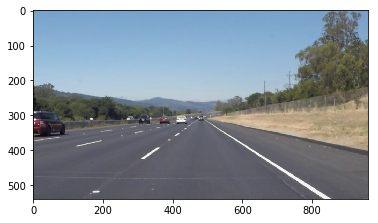

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [11]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def separate_lanes(img, lines, min_slope):
    """
    This function filters an image of Hough Lines based on minimum slope and
    then separates them by slope into right and left lanes.  Finally it averages
    the right and left segments and extrapolates them as needed to come up with
    a right and left lane line"""
    right_segments = []
    left_segments = []
    lanes = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            # filter lines by slope: assumption is lane line slope is between bottom corners to center of pic
            # added min_slope as an input paramter to this function
            if (x2-x1) != 0:
                # in case of a vertical segment
                slope = ((y2-y1)/(x2-x1))
                intercept = y2-slope*x2
                # separate the left and right lanes based on negative and positive slope(y increases down)
                if abs(slope) > min_slope:
                    # extrapolate by averaging line slopes on positive & negative side before drawing
                    if slope > 0:
                        right_segments.append([x1,y1,x2,y2,slope,intercept])
                    else:
                        left_segments.append([x1,y1,x2,y2,slope,intercept])
   
    # determine bottom and top of extrapolated lane lines
    y_bot = img.shape[0]
    y_top = int(3*y_bot/5)
    # calculate average lines and plot
    
    right_means = np.mean(right_segments, axis=0)
    # check for nan(not a number) in the arrays
    # http://stackoverflow.com/questions/6736590/fast-check-for-nan-in-numpy
    if not(np.isnan(np.sum(right_means))):
        #print("right_means = ", right_means)
        # determine right and left lane line endpoints
        # add intersection test later?
        x_bot_r = int((y_bot-right_means[5])/right_means[4])
        x_top_r = int((y_top-right_means[5])/right_means[4])
        # note that extra [] is needed to make lanes iterable
        lanes.append([[x_bot_r,y_bot,x_top_r,y_top]])
    
    left_means = np.mean(left_segments, axis=0)
    if not(np.isnan(np.sum(left_means))):
        #print("left_means = ", left_means)
        x_bot_l = int((y_bot-left_means[5])/left_means[4])
        x_top_l = int((y_top-left_means[5])/left_means[4])   
        lanes.append([[x_bot_l,y_bot,x_top_l,y_top]])
        return lanes

def draw_lines(img, lines, min_slope, color=[255, 0, 0], thickness=20):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    lanes = separate_lanes(img, lines, min_slope)
    if lanes:
        for line in lanes:
            for x1,y1,x2,y2 in line:        
            # draw lines
            # cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, min_slope):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, min_slope)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def pipeline(image):
    # get image size
    x = image.shape[1]
    y = image.shape[0]
    # calculate fractions of image size to use for masking assuming lanes in lower portion of image
    x_10 = int(x/10)
    y_2 = int(y/2)
    #grayscale the image
    gray = grayscale(image)
    # kernel size 5 for gaussian blur
    blur_gray = gaussian_blur(gray, 5)
    # run Canny edge detection
    low_threshold = 70
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    #plt.imshow(edges)
    # mask the image using fractions of image size assuming lane will be in lower portion of frame
    poly_verts = np.array([[(x_10,y), (4*x_10,y_2), (6*x_10, y_2), (9*x_10, y)]],dtype=np.int32)
    masked_image = region_of_interest(edges, poly_verts)
    # Define the Hough transform parameters
    rho = 2
    theta = np.pi/180
    threshold = 100
    min_line_length = 40
    max_line_gap = 15
    # I added min_slope to filter lines which aren't likely lane lines
    # assumption is lane line slope is between bottom corners to center of pic
    # ***note the filter and extrapolate assumptions only work if car is in the lane
    #    as is the case for all tests here.  Need a more robust algorithm in future
    #    to accomodate crossing lanes, turning, etc ***
    min_slope = y_2/(5*x_10)
    # Run Hough on masked, edge detected image
    lines = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap, min_slope)
    #plt.imshow(lines)
    #generate a weighted image with the masked lane lines
    result = weighted_img(lines, image, α=0.8, β=1., λ=0.)
    return result

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [20]:
import os
files = os.listdir("test_images/")
print(files)

['.DS_Store', 'challenge_shot.jpg', 'solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']


run your solution on all test_images and make copies into the test_images directory).

processing:  test_images/challenge_shot.jpg
writing:  test_image_output/challenge_shot.jpg
processing:  test_images/solidWhiteCurve.jpg
writing:  test_image_output/solidWhiteCurve.jpg
processing:  test_images/solidWhiteRight.jpg
writing:  test_image_output/solidWhiteRight.jpg
processing:  test_images/solidYellowCurve.jpg
writing:  test_image_output/solidYellowCurve.jpg
processing:  test_images/solidYellowCurve2.jpg
writing:  test_image_output/solidYellowCurve2.jpg
processing:  test_images/solidYellowLeft.jpg
writing:  test_image_output/solidYellowLeft.jpg
processing:  test_images/whiteCarLaneSwitch.jpg
writing:  test_image_output/whiteCarLaneSwitch.jpg


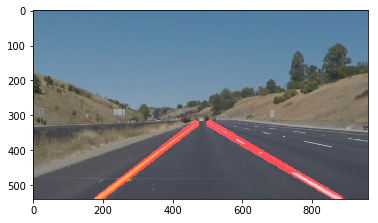

In [28]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
# NOTE: I used a separate directory for output and also added an image
#       from the challenge video which my pipeline doesn't work with
#       Decided to tackle the challenge later so the pipeline still
#       isn't working on that section of video: challenge.jpg
for file in files:
    filename, filext = os.path.splitext(file)
    if filext.lower().endswith(('.jpg', '.jpeg', '.png')):
        
        image_in = 'test_images/' + file
        print("processing: ", image_in)
        image = mpimg.imread(image_in)
        result = pipeline(image)
        plt.imshow(result)
        image_out = 'test_image_output/' + file
        print("writing: ", image_out)
        mpimg.imsave(image_out, result)



In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    # get image dimensions for slope filter and masking
    result = pipeline(image)
    plt.imshow(result)
    return result

Let's try the one with the solid white lane on the right first ...

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:09<00:00, 23.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 7.46 s, sys: 1.38 s, total: 8.83 s
Wall time: 10.6 s


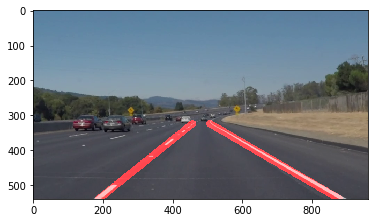

In [16]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:31<00:00, 21.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 23.9 s, sys: 4.07 s, total: 27.9 s
Wall time: 32.4 s


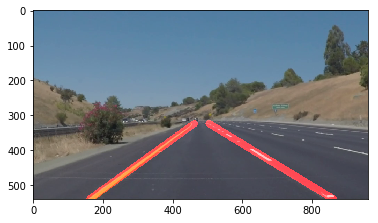

In [27]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


### Areas of weakness for current algorithm:
* Separating lane lines by slope is only effective when the car is already in the lane and the car is not on a sharp curve because the angle at which the car/camera sits relative to the lane impacts the slopes which can be used both to separate lanes and for filtering lines detected by the Hough algorithm which are unlikely to be part of the lanes
* Region of interest masking as implemented here is also only effective if the car is already in the lane.  If the car were making a left turn for example or changing lanes the region of interest to detect the new lane would be in a different location and would eventually end up in the lower center again once the car was in the new lane.
* The challenge problem demonstrates some other areas of weakness.  While I ran my algorithm on the challenge, I didn't spend time tweaking it to address the deficiences. The current Canny and Hough parameters don't work well on the challenge problem when the pavement is very light(the thresholds on Canny likely need adjusted.  Additionally, the lane has a sharper curve so the slope lane separation algorithm is likley taking some of the right lane curve segments and averaging them into the left lane due to the curve impacting their slope.

### Possible improvements:
* Tracking the lanes frame to frame and using prior location for things like region of interest adjustment, possible color filtering, and possibly even parameter adjustments in the Canny and Hough algorithms.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4



100%|██████████| 251/251 [00:27<00:00,  7.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 17.3 s, sys: 3.41 s, total: 20.7 s
Wall time: 29.5 s


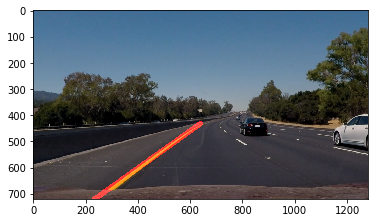

In [27]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))